# SET TRAIN & TEST VOLUME

### build dataset for one month

In [5]:
from util.build_dataset import build_master

dataset = build_master(bucket_name="production-bobsim", dataset="process_fmp", date="201908", pipe_data=False)

2020-04-09 09:37:44:manage:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-04-09 09:37:44:manage:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-04-09 09:37:44:manage:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201908.csv in s3 'production-bobsim'


In [101]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from model.elastic_net import ElasticNetModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import functools
from util.visualize import draw_hist
from util.s3_manager.manage import S3Manager

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["price", "date"]), df["price"]

def split_train_test(str_day, std_day, df: pd.DataFrame):
    train = df[(str_day <= df["date"].dt.date) & (df["date"].dt.date < std_day)]
    test = df[df["date"].dt.date >= std_day]
    return train, test


def get_score(train_size, test_size, df):
    time_series = df["date"].drop_duplicates().tolist()
    std_day = time_series[-1*test_size]
    str_day = time_series[-1*(test_size+train_size)]
    train, test = split_train_test(str_day=str_day, std_day=std_day, df=df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    params = {'alpha': 0.0001, 'l1_ratio': 0.9, 'max_iter': 5}
    regr = ElasticNet(**params)
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    
    mean, std = S3Manager(bucket_name="production-bobsim").load_dump(
            key="food_material_price_predict_model/price_(mean,std).pkl"
        )
    
    metric = customized_rmse(y_test*std+mean, y_pred*std+mean)
    return metric



def rmse_by_train_size(df):
    test_size = 5
    train_sizes = range(1,16)
    score_list = list(map(functools.partial(get_score, test_size=test_size, df=df), train_sizes))
    ser = pd.Series(score_list, index=train_sizes)
    print(ser)
    
    plt.xlabel('train size')
    plt.ylabel('customized RMSE')
    ser.plot(kind="bar", ylim=(ser.min()-1,ser.max()+1), color="blue", title="test_size: {}".format(test_size))
    S3Manager(bucket_name="production-bobsim").save_plt_to_png(key="food_material_price_predict_model/image/rmse_by_train_size_201908.png")
    
    # draw_hist(ser, h_type="dist")
    # print("metric list for standard '{day}': {metrics}".format(day=standard_day, metrics=score_list))


def split_train_test2(std_day, end_day, df: pd.DataFrame):
    train = df[df["date"].dt.date <= std_day] 
    test = df[(std_day < df["date"].dt.date) & (df["date"].dt.date <= end_day )]
    return train, test

def get_score2(test_size, train_size, df):
    time_series = df["date"].drop_duplicates().tolist()
    std_day = time_series[train_size]
    end_day = time_series[test_size+train_size]
    print(end_day, std_day)
    train, test = split_train_test2(std_day=std_day, end_day=end_day, df=df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    params = {'alpha': 0.0001, 'l1_ratio': 0.9, 'max_iter': 5}
    regr = ElasticNet(**params)
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    
    mean, std = S3Manager(bucket_name="production-bobsim").load_dump(
            key="food_material_price_predict_model/price_(mean,std).pkl"
        )
    
    metric = customized_rmse(y_test*std+mean, y_pred*std+mean)
    return metric


def rmse_by_test_size(df):
    test_sizes = range(1,7)
    train_size = 14
    score_list = list(map(functools.partial(get_score2, train_size=train_size, df=df), test_sizes))
    ser = pd.Series(score_list, index=test_sizes)
    print(ser)
    
    plt.xlabel('test size')
    plt.ylabel('customized RMSE')
    ser.plot(kind="bar", ylim=(ser.min()-1,ser.max()+1), color='red', title="train_size: {}".format(train_size))
    S3Manager(bucket_name="production-bobsim").save_plt_to_png(key="food_material_price_predict_model/image/rmse_by_test_size_201908.png")
    
    

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.714235129859077, tolerance: 0.16383815923631115
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.53939160690132, tolerance: 0.3244808170308517
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.89925266697378, tolerance: 0.481055700360773
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

1     821.968670
2     820.962940
3     822.560033
4     824.313692
5     825.896387
6     827.288438
7     830.864456
8     831.905845
9     832.834150
10    833.427893
11    834.385738
12    835.232139
13    835.593942
14    836.243278
15    836.691582
dtype: float64


2020-04-09 10:50:04:manage:<INFO> success to save 'food_material_price_predict_model/image/rmse_by_train_size_201908.png' in s3 'production-bobsim'


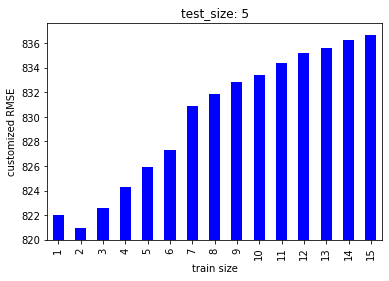

<Figure size 432x288 with 0 Axes>

In [102]:
rmse_by_train_size(dataset)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-06 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-07 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-08 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-09 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-12 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-13 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-14 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-16 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-19 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-20 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-21 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-22 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-23 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-26 00:00:00 2019-08-05 00:00:00


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.38376714962152, tolerance: 0.479896611929776
  positive)


2019-08-27 00:00:00 2019-08-05 00:00:00
1     854.792763
2     857.031577
3     854.664075
4     852.955344
5     850.812280
6     847.029172
7     845.496428
8     843.185251
9     839.020461
10    839.039687
11    839.789238
12    844.056307
13    846.092454
14    848.809803
15    848.162019
dtype: float64


2020-04-09 10:48:10:manage:<INFO> success to save 'food_material_price_predict_model/image/rmse_by_test_size_201908.png' in s3 'production-bobsim'


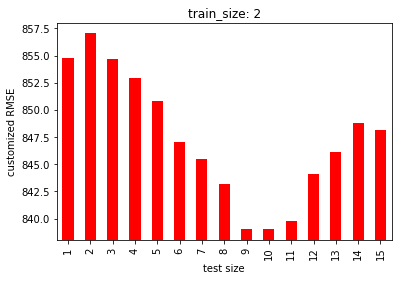

<Figure size 432x288 with 0 Axes>

In [100]:
rmse_by_test_size(dataset)

In [4]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(alpha=0, l1_ratio=0.0, max_iter=5)
en.fit(train_x, train_y)
pred = en.predict(test_x)
model_pipeline.customized_rmse(test_y, pred)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2960803954.906143, tolerance: 16733436.770004129
  positive)


568.4727293334064